In [2]:
# https://www.kaggle.com/code/alekseytrepetsky/create-chemberta-embed

from IPython.display import clear_output as clr
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoModelForMaskedLM, AutoTokenizer

chemberta = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
chemberta.eval()

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): 

In [19]:
def featurize_ChemBERTa(smiles_list, padding=True):
    embeddings_cls = torch.zeros(len(smiles_list), 600)
    embeddings_mean = torch.zeros(len(smiles_list), 600)

    with torch.no_grad():
        for i, smiles in enumerate(tqdm(smiles_list)):
            encoded_input = tokenizer(smiles, return_tensors="pt", padding=padding, truncation=True)
            model_output = chemberta(**encoded_input)
            
            embedding = model_output[0][::,0,::]
            embeddings_cls[i] = embedding
            
            embedding = torch.mean(model_output[0],1)
            embeddings_mean[i] = embedding
            
    return embeddings_cls, embeddings_mean

In [7]:
df_de_train = pd.read_parquet('../../data/de_train.parquet')

In [20]:
df_compound = df_de_train[['sm_name', 'SMILES']].drop_duplicates()

In [21]:
df_compound

,sm_name,SMILES
0,Clotrimazole,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
4,Mometasone Furoate,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...
8,Idelalisib,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...
14,Vandetanib,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1
18,Bosutinib,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...
...,...,...
594,CGM-097,COc1cc2c(cc1OC(C)C)[C@H](c1ccc(Cl)cc1)N(c1ccc(...
598,TGX 221,Cc1cc(C(C)Nc2ccccc2)c2nc(N3CCOCC3)cc(=O)n2c1
602,Azacitidine,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1
606,Atorvastatin,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...


In [22]:
cls_pad_true, mean_pad_true = featurize_ChemBERTa(df_compound.SMILES)

100%|██████████| 146/146 [00:02<00:00, 52.32it/s]


In [23]:
mean_pad_true.shape

torch.Size([146, 600])

In [24]:
cls_pad_true.shape

torch.Size([146, 600])

In [27]:
compound_embedding = torch.concat([mean_pad_true, mean_pad_true], dim=1).numpy()

In [28]:
compound_embedding.shape

(146, 1200)

In [29]:
from sklearn.decomposition import PCA

In [30]:
pca = PCA(n_components=30)

In [31]:
compound_embedding_pca = pca.fit_transform(compound_embedding)

In [33]:
compound_embedding_pca

array([[-7.7318358e-01,  3.8546926e-01,  2.9822509e+00, ...,
         5.7290226e-01, -1.7080216e-01,  4.9482871e-02],
       [ 1.5181581e+01, -5.7388144e+00, -7.4951630e+00, ...,
         1.8336873e+00, -6.1421877e-01, -7.3763669e-02],
       [ 5.2579870e+00, -5.9537368e+00,  9.4200592e+00, ...,
         1.0815463e-02,  1.6669923e+00,  9.5930742e-03],
       ...,
       [ 2.0170092e+01,  7.9075593e-01,  6.0351286e+00, ...,
         1.0793709e+00, -9.7040141e-01,  3.9092433e-01],
       [-1.0845474e+01,  1.7207084e+00, -7.0401711e+00, ...,
        -2.6932517e-01,  7.5054562e-01, -8.2853323e-01],
       [ 3.7087047e+00, -7.6722307e+00,  4.0141196e+00, ...,
         6.2750465e-01,  1.3295443e+00, -4.7383767e-01]], dtype=float32)

In [45]:
df_embedding = pd.DataFrame(compound_embedding_pca, columns=['PC_' + str(i) for i in range(30)])
df_embedding['sm_name'] = df_compound['sm_name'].values
df_embedding['SMILES'] = df_compound['SMILES'].values

In [46]:
import seaborn as sns

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/zl_scp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/zl_scp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='PC_0', ylabel='PC_1'>

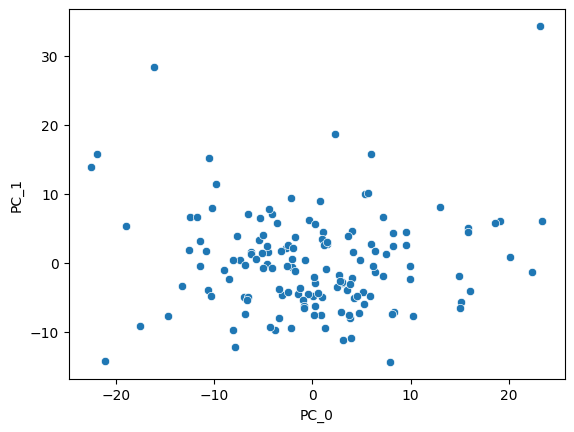

In [47]:
sns.scatterplot(df_embedding, x='PC_0', y='PC_1')

In [48]:
df_embedding.to_csv('../../results/ChemBERTa-77M-MTR/df_embedding.csv')